# Data inspection in BigQuery

## BigQuery Authentication

In [1]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

In [2]:
import pandas_gbq

pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = "perfect-operand-267716"

## Porpouse

The analysis I'm going to do is direct to analyse the sentiment of the politics comments in Reddit.

The subreddits analyzed for this purpose will be:

*  /r/Politics
*  /r/worldpolitics
*  /r/neoliberal
*  /r/Libertarian
*  /r/anarchism
*  /r/socialism
*  /r/conservative
*  /r/hillaryclinton
*  /r/asktrumpsupporters
*  /r/politicalhumor
*  /r/neutralpolitics
*  /r/politicaldiscussion
*  /r/ukpolitics
*  /r/latestagecapitalism
*  /r/geopolitics




## Global analysis

In [3]:
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq

I start exploring the data, with the following query, for comments and posts:


In [4]:
comments = """WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    body,
    created_utc
  FROM
    `fh-bigquery.reddit_comments.20*`
  WHERE
    subreddit IN ('politics',
      'worldpolitics',
      'neoliberal',
      'Libertarian',
      'Anarchism',
      'socialism',
      'Conservative',
      'hillaryclinton',
      'AskTrumpSupporters',
      'PoliticalHumor',
      'NeutralPolitics',
      'PoliticalDiscussion',
      'ukpolitics',
      'LateStageCapitalism',
      'geopolitics')
    AND body != '[deleted]'
    AND body != '[removed]'
    AND body != '[ Removed by reddit in response to a copyright notice. ]'
    AND body != 'NaN'
    AND body != ''),
  q2 AS (
  SELECT
    DISTINCT(subreddit) uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(body) AS number_comments,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    4,
    5
  ORDER BY
    number_comments DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_comments,
  year,
  month
FROM
  q2
ORDER BY
  number_comments DESC"""
politics_comments = gbq.read_gbq(query=comments, dialect ='standard', project_id='perfect-operand-267716')
politics_comments.head()

Downloading: 100%|██████████| 1621/1621 [00:01<00:00, 1576.28rows/s]


,uniq_subreddit,num_uniq_authors,number_comments,year,month
0,politics,173962,2433366,2016,11
1,politics,218931,2366194,2019,1
2,politics,138251,2065611,2016,10
3,politics,156316,2052939,2017,1
4,politics,199658,2047185,2019,10


In [5]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [6]:
politics_comments.columns

Index(['uniq_subreddit', 'num_uniq_authors', 'number_comments', 'year',
       'month'],
      dtype='object')

In [7]:
politics_comments['date'] = politics_comments['year'].map(str) + '-' + politics_comments['month'].map(str)

In [8]:
politics_comments.head()

,uniq_subreddit,num_uniq_authors,number_comments,year,month,date
0,politics,173962,2433366,2016,11,2016-11
1,politics,218931,2366194,2019,1,2019-1
2,politics,138251,2065611,2016,10,2016-10
3,politics,156316,2052939,2017,1,2017-1
4,politics,199658,2047185,2019,10,2019-10


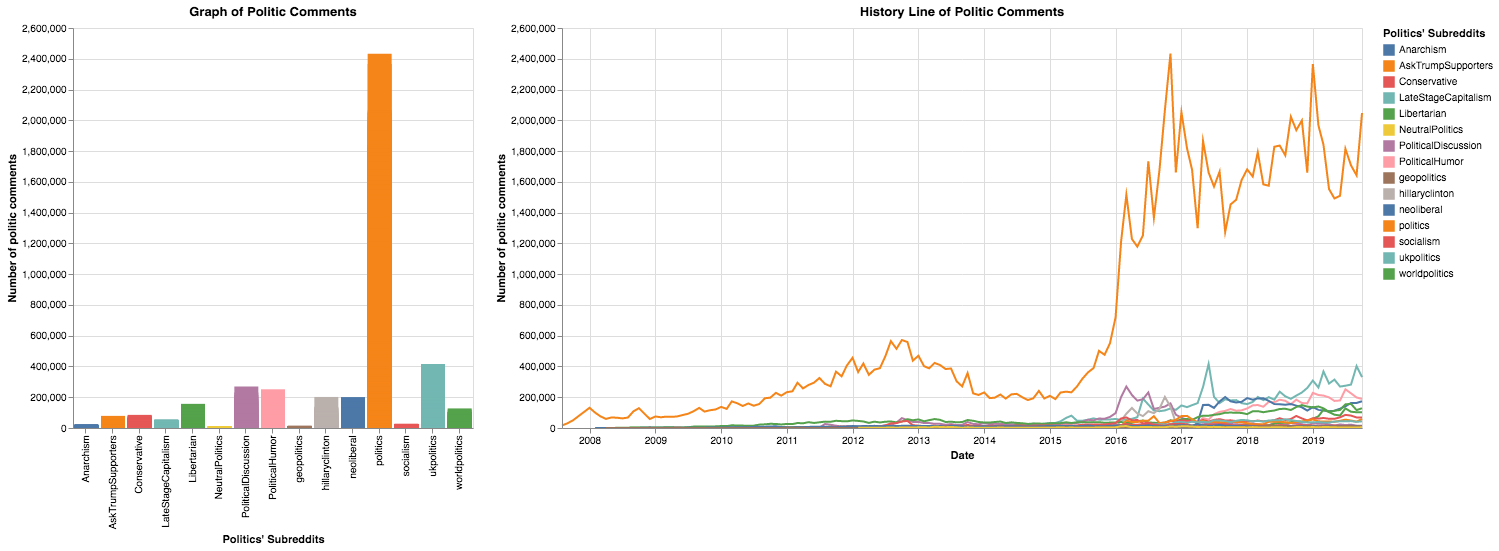

In [9]:
select_search_term = alt.selection_single(encodings=["x"])

trends_line = alt.Chart(politics_comments).mark_line().encode(
    x=alt.X("date:T", title='Date'),
    y=alt.Y("number_comments", title='Number of politic comments'),
    color=alt.Color("uniq_subreddit", title="Politics' Subreddits")
).transform_filter(
    select_search_term
).properties(
    width = 800, 
    height= 400,
    title="History Line of Politic Comments"
)


trends_bar = alt.Chart(politics_comments).mark_bar().encode(
    x=alt.X("uniq_subreddit", title="Politics' Subreddits"),
    y=alt.Y("number_comments", title='Number of politic comments'),
    color=alt.Color("uniq_subreddit", title="Politics' Subreddits")
).properties(
    selection=select_search_term
).properties(
    width = 400, 
    height= 400,
    title="Graph of Politic Comments"
)


trends_bar|trends_line

In [10]:
posts = """WITH
  q1 AS(
  SELECT
    subreddit,
    author,
    selftext,
    title,
    created_utc
  FROM
    `fh-bigquery.reddit_posts.20*`
  WHERE
    subreddit IN ('politics',
      'worldpolitics',
      'neoliberal',
      'Libertarian',
      'Anarchism',
      'socialism',
      'Conservative',
      'hillaryclinton',
      'AskTrumpSupporters',
      'PoliticalHumor',
      'NeutralPolitics',
      'PoliticalDiscussion',
      'ukpolitics',
      'LateStageCapitalism',
      'geopolitics')
    AND ((LENGTH(title) > 5
        AND LENGTH(selftext) > 10)
      OR ((selftext != '[deleted]'
          AND LENGTH(title) > 5)
        AND (selftext != '[removed]'
          AND LENGTH(title) > 5)
        AND (selftext != '[ Removed by reddit in response to a copyright notice. ]'
          AND LENGTH(title) > 5)
        AND (selftext != 'NaN'
          AND LENGTH(title) > 5)
        AND (selftext != ''
          AND LENGTH(title) > 5)))),
  q2 AS (
  SELECT
    DISTINCT(subreddit) AS uniq_subreddit,
    COUNT(DISTINCT(author)) AS num_uniq_authors,
    COUNT(title) AS number_posts,
    EXTRACT(YEAR
    FROM
      TIMESTAMP_SECONDS(created_utc)) year,
    EXTRACT(month
    FROM
      TIMESTAMP_SECONDS(created_utc)) month
  FROM
    q1
  GROUP BY
    1,
    4,
    5
  ORDER BY
    number_posts DESC)
SELECT
  uniq_subreddit,
  num_uniq_authors,
  number_posts,
  year,
  month
FROM
  q2
ORDER BY
  number_posts DESC"""
politics_posts = gbq.read_gbq(query=posts, dialect ='standard', project_id='perfect-operand-267716')
politics_posts.head()

Downloading: 100%|██████████| 652/652 [00:00<00:00, 722.97rows/s]


,uniq_subreddit,num_uniq_authors,number_posts,year,month
0,PoliticalDiscussion,1393,2327,2016,3
1,ukpolitics,1292,2201,2017,6
2,PoliticalDiscussion,1214,2043,2016,2
3,AskTrumpSupporters,1389,1829,2016,3
4,PoliticalDiscussion,852,1431,2016,4


In [11]:
politics_posts.columns

Index(['uniq_subreddit', 'num_uniq_authors', 'number_posts', 'year', 'month'], dtype='object')

In [12]:
politics_posts['date'] = politics_posts['year'].map(str) + '-' + politics_posts['month'].map(str)
politics_posts.head()

,uniq_subreddit,num_uniq_authors,number_posts,year,month,date
0,PoliticalDiscussion,1393,2327,2016,3,2016-3
1,ukpolitics,1292,2201,2017,6,2017-6
2,PoliticalDiscussion,1214,2043,2016,2,2016-2
3,AskTrumpSupporters,1389,1829,2016,3,2016-3
4,PoliticalDiscussion,852,1431,2016,4,2016-4


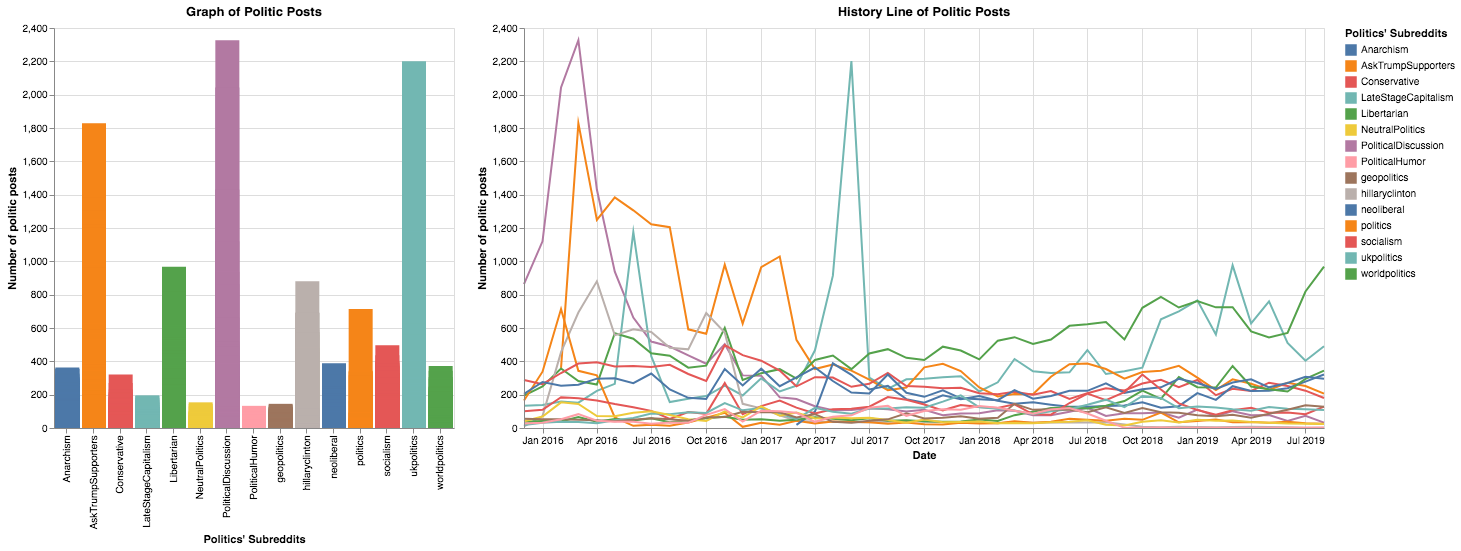

In [13]:
select_search_term = alt.selection_single(encodings=["x"])

trends_line = alt.Chart(politics_posts).mark_line().encode(
    x=alt.X("date:T", timeUnit="yearmonth", title='Date'),
    y=alt.Y("number_posts", title='Number of politic posts'),
    color=alt.Color("uniq_subreddit", title="Politics' Subreddits")
).transform_filter(
    select_search_term
).properties(
    width = 800, 
    height= 400,
    title="History Line of Politic Posts"
)


trends_bar = alt.Chart(politics_posts).mark_bar().encode(
    x=alt.X("uniq_subreddit", title="Politics' Subreddits"),
    y=alt.Y("number_posts", title='Number of politic posts'),
    color=alt.Color("uniq_subreddit", title="Politics' Subreddits")
).properties(
    selection=select_search_term
).properties(
    width = 400, 
    height= 400,
    title="Graph of Politic Posts"
)


trends_bar|trends_line